# Data Fusion with Filters

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from filters import fusion, kalman
from models import const_acc, const_vel, noise
from plots import plot_common, plot_fusion, plot_kf
from simulators import datagen, linear, radar

## Sensor Fusion

fusion std: 1.647


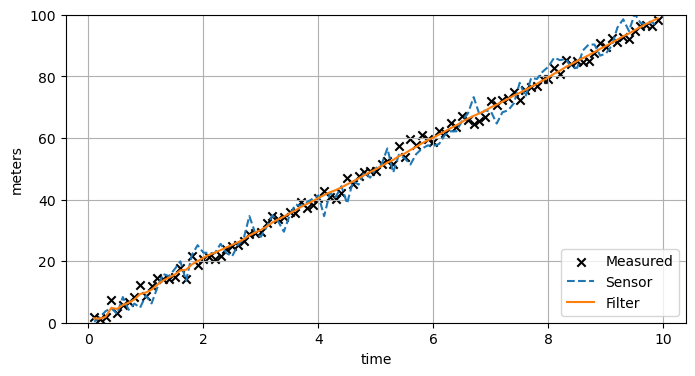

In [3]:
_, ax = plt.subplots(figsize=(8, 4))

saver = fusion.fusion_kf2d(1.5, 3.0)
plot_fusion.plot_fusion_kf2d(ax, saver)

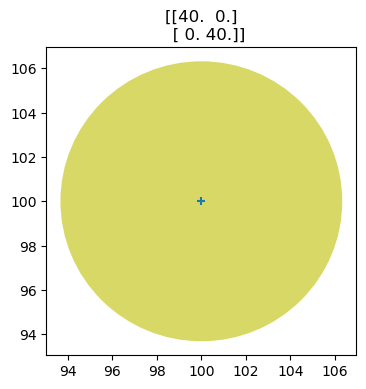

In [4]:
def fx(x, dt):
    """predict state x at 'dt' time in the future"""
    return x


def hx(x, refpos=(0, 0)):
    """compute measurements corresponding to state x"""
    range_, angle = radar.H2dRE(x, refpos=refpos)
    return angle, range_


kf = fusion.fusion_ukf2d(hx=hx, fx=fx)
x0, p0 = kf.x.copy(), kf.P.copy()

_, ax = plt.subplots(figsize=(4, 4))
plot_common.plot_cov_ellipse(ax, x0, p0, facecolor="y", edgecolor=None, alpha=0.6)

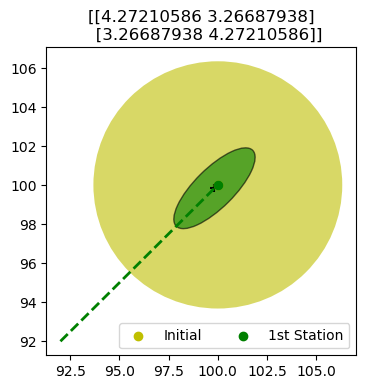

In [5]:
kf.R[0, 0] = math.radians(0.5) ** 2
kf.R[1, 1] = 3.0**2

# compute position and covariance from first station
dist, _ = radar.H2dRE([0, 0], refpos=(50, 50))
kf.predict()
kf.update([math.radians(45), dist], refpos=(50, 50))

_, ax = plt.subplots(figsize=(4, 4))
x1, p1 = kf.x.copy(), kf.P.copy()

plot_common.plot_cov_ellipse(ax, x0, p0, facecolor="y", edgecolor=None, alpha=0.6)
plot_common.plot_cov_ellipse(ax, x1, p1, facecolor="g", edgecolor="k", alpha=0.6)
ax.scatter([100], [100], c="y", label="Initial")
ax.scatter([100], [100], c="g", label="1st Station")
ax.plot([92, 100], [92, 100], c="g", lw=2, ls="--")
ax.legend(ncol=2)

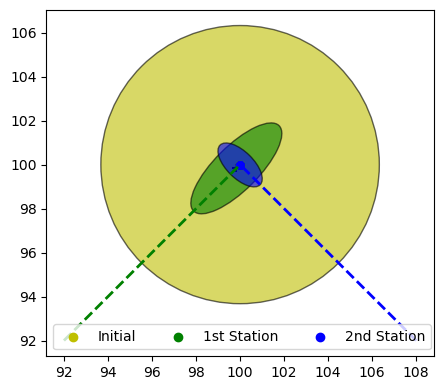

In [6]:
kf.predict()
kf.update([math.radians(135), dist], refpos=(150, 50))

_, ax = plt.subplots(figsize=(5, 4.5))

plot_common.plot_cov_ellipse(
    ax, x0, p0, facecolor="y", edgecolor="k", alpha=0.6, show_title=False
)
plot_common.plot_cov_ellipse(
    ax, x1, p1, facecolor="g", edgecolor="k", alpha=0.6, show_title=False
)
plot_common.plot_cov_ellipse(
    ax, kf.x, kf.P, facecolor="b", edgecolor="k", alpha=0.6, show_title=False
)
ax.scatter([100], [100], c="y", label="Initial")
ax.scatter([100], [100], c="g", label="1st Station")
ax.scatter([100], [100], c="b", label="2nd Station")
ax.plot([92, 100], [92, 100], c="g", lw=2, ls="--")
ax.plot([108, 100], [92, 100], c="b", lw=2, ls="--")
ax.legend(ncol=3)

# plt.savefig("../images/fusion-radar.png")

### GPS


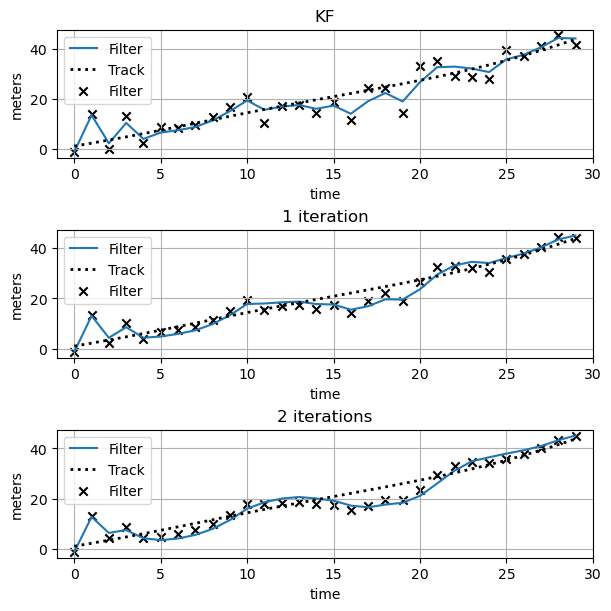

In [7]:
np.random.seed(124)

R = 5.0
Q = 0.02
caobj = linear.CAObject(Q=Q, R=R)
xs, zs = caobj.simulate(count=30)
kf0 = const_acc.KFCA3d(P=100, R=R, Q=Q, dt=1)
kf1 = const_acc.KFCA3d(P=100, R=R, Q=Q, dt=1)
kf2 = const_acc.KFCA3d(P=100, R=R, Q=Q, dt=1)

fxs0, ps0, _, _ = kf0.batch_filter(zs)
# filter twice more, using the state as the input
fxs1, ps1, _, _ = kf1.batch_filter(fxs0[:, 0])
fxs2, _, _, _ = kf2.batch_filter(fxs1[:, 0])

_, axes = plt.subplots(3, 1, figsize=(6, 6), constrained_layout=True)

plot_kf.plot_kf_track(axes[0], xs, fxs0, zs, label="Filter", title="KF")
plot_kf.plot_kf_track(
    axes[1], xs, fxs1, fxs0[:, 0], label="Filter", title="1 iteration"
)
plot_kf.plot_kf_track(
    axes[2], xs, fxs2, fxs1[:, 0], label="Filter", title="2 iterations"
)

### Different Data Rates


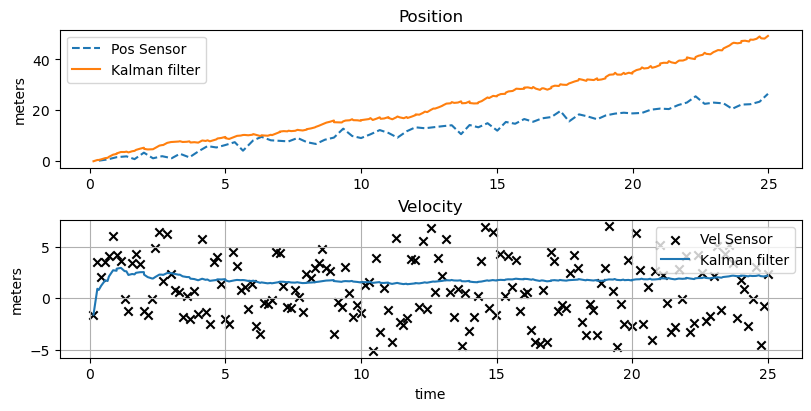

In [8]:
def fusion_test(axes, pos_data, vel_data, pos_std, vel_std):
    kf = kalman.KalmanFilter(dim_x=2, dim_z=1)
    kf.F = const_vel.FCV(dim=2, dt=1)
    kf.H = np.array([[1.0, 0.0], [1.0, 0.0]])
    kf.x = np.array([[0.0], [1.0]])
    kf.P *= 100
    xs, ts = [], []
    # copy data for plotting
    zs_pos = np.array(pos_data)
    zs_vel = np.array(vel_data)

    last_t = 0
    while len(pos_data) * len(vel_data) > 0:
        if pos_data[0][0] < vel_data[0][0]:
            t, z = pos_data.pop(0)
            dt = t - last_t
            last_t = t
            kf.R[0, 0] = pos_std**2
        else:
            t, z = vel_data.pop(0)
            dt = t - last_t
            last_t = t
            kf.H = np.array([[0.0, 1.0]])
            kf.R[0, 0] = vel_std**2

        kf.F[0, 1] = dt
        kf.Q = noise.white_noise_discrete(2, dt=dt, var=0.02)
        kf.predict()
        kf.update(np.array([z]))

        xs.append(kf.x.T[0])
        ts.append(t)

    plot_fusion.plot_fusion_kf(axes, xs, ts, zs_pos, zs_vel)


_, axes = plt.subplots(2, 1, figsize=(8, 4), constrained_layout=True)

pos_data, vel_data = datagen.gen_sensor_data(25, 1.5, 3.0)
fusion_test(axes, pos_data, vel_data, pos_std=3.0, vel_std=1.5)